In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files
import torchvision.models as models

In [ ]:
uploaded = files.upload()

import zipfile
import io

zip_name = next(iter(uploaded))
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

Saving FERPlus.zip to FERPlus.zip


In [ ]:
BATCH_SIZE = 256
EPOCHS = 30
NUM_CLASSES = 7
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BASE_PATH = '/content'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')

In [ ]:
EMOTION_LABELS = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [ ]:
print(f"Using device: {DEVICE}")
print(f"Training data path: {TRAIN_PATH}")
print(f"Testing data path: {TEST_PATH}")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Add random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color variations
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translations
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_transform
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


Using device: cuda:0
Training data path: /content/train
Testing data path: /content/test
Number of training samples: 58379
Number of testing samples: 7341


In [ ]:
def train(model, device, train_loader, optimizer):
    model.train()

    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (input, target) in enumerate(train_loader):
        input = input.to(DEVICE)
        target = target.type(torch.LongTensor).to(DEVICE)

        optimizer.zero_grad()
        output = model(input)

        loss = nn.CrossEntropyLoss()
        loss_value = loss(output, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value
        train_correct += torch.sum(torch.argmax(output, dim=1) == target)
        train_total += input.shape[0]

    avg_loss = train_loss.item() / len(test_loader)
    accuracy = (train_correct / train_total).item()

    return avg_loss, accuracy

In [ ]:
def test(model, device, test_loader, optimizer):
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(test_loader):
            input = input.to(DEVICE)
            target = target.type(torch.LongTensor).to(DEVICE)

            output = model(input)
            predictions = torch.argmax(output, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            loss = nn.CrossEntropyLoss()
            loss_value = loss(output, target)

            test_loss += loss_value.item()
            test_correct += torch.sum(torch.argmax(output, dim=1) == target).item()
            test_total += input.shape[0]

    cm = confusion_matrix(all_targets, all_predictions)
    test_loss = test_loss / len(test_loader)
    accuracy = test_correct / test_total

    return test_loss, accuracy, cm

In [ ]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES))

model = resnet50.to(DEVICE)
model.conv1.activation = nn.ReLU()

optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, DEVICE, train_loader, optimizer)
    test_loss, test_acc, cm = test(model, DEVICE, test_loader, optimizer)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%')

    if epoch == 49:

      plt.figure(figsize=(10, 10))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=EMOTION_LABELS.values(),
                  yticklabels=EMOTION_LABELS.values())
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.title('Confusion Matrix')
      plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30:
Train Loss: 6.8226 | Train Acc: 69.09%
Test Loss: 1.3380 | Test Acc: 59.39%
Epoch 2/30:
Train Loss: 5.5766 | Train Acc: 75.40%
Test Loss: 1.4816 | Test Acc: 59.39%
Epoch 3/30:
Train Loss: 5.2309 | Train Acc: 77.07%
Test Loss: 1.4973 | Test Acc: 55.10%
Epoch 4/30:
Train Loss: 5.3313 | Train Acc: 76.51%
Test Loss: 0.8679 | Test Acc: 70.69%
Epoch 5/30:
Train Loss: 5.0274 | Train Acc: 77.93%
Test Loss: 1.1191 | Test Acc: 62.72%
Epoch 6/30:
Train Loss: 4.7844 | Train Acc: 78.75%
Test Loss: 1.1837 | Test Acc: 64.02%
Epoch 7/30:
Train Loss: 4.5522 | Train Acc: 80.26%
Test Loss: 0.9657 | Test Acc: 67.32%
Epoch 8/30:
Train Loss: 4.6755 | Train Acc: 79.38%
Test Loss: 1.2019 | Test Acc: 63.62%
Epoch 9/30:
Train Loss: 3.5383 | Train Acc: 84.74%
Test Loss: 0.8995 | Test Acc: 72.12%
Epoch 10/30:
Train Loss: 3.4633 | Train Acc: 85.20%
Test Loss: 0.8109 | Test Acc: 74.13%
Epoch 11/30:
Train Loss: 3.2127 | Train Acc: 86.03%
Test Loss: 0.8160 | Test Acc: 73.95%
Epoch 12/30:
Train Loss: 3.154

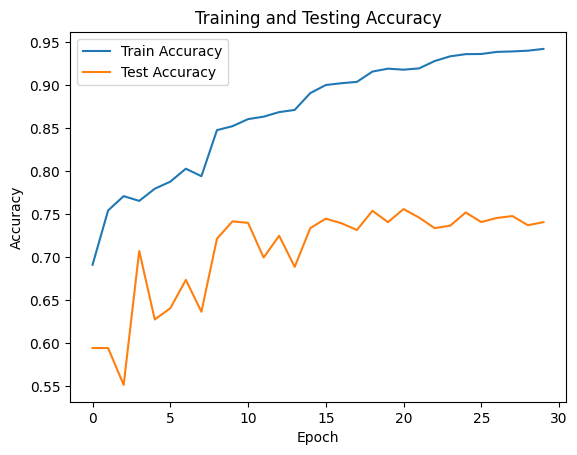

In [ ]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()